# Task 5.2HD - Minor research project
**Demonstration**

The following notebook contains the code and demonstration for SIT789 Task 5.2HD “minor research project”. The chosen paper was [*Multi-Metric Optimization using Generative Adversarial Networks for Near-End Speech Intelligibility Enhancement*](https://arxiv.org/pdf/2104.08499.pdf) on the topic of speech intelligibility enhancement.

For the associated report and discussion, please see the attached pdf document.

---

# Set-up

Note the current notebook is being run on a Google Cloud VM. This is due to the requirement for CUDA (GPU) in the original papers model. The specifications have been chosen to be compatible with the software versions specified in https://github.com/nii-yamagishilab/NELE-GAN/tree/master

The specifications of the VM are:
| Property | Value |
| -- | -- |
| Machine Type | n1-standard-4 |
| Operating System| Debian 10 |
| CPU Platform | Intel Broadwell |
| CPU | 4 vCPU 16Gb RAM |
| GPU | 1 x NVIDIA T4 |

The following code is used to set-up the environment to mimic the original paper and install all dependencies.

In [1]:
# Check the python version
!python -V

Python 3.7.12


In [ ]:
!pip install librosa==0.7.1 numpy==1.17.2 numba==0.48 matplotlib==3.1.1 pandas==1.0.0 --force-reinstall

In [ ]:
# Install requirements for Intelligibility and Quality metrics
!pip install git+https://github.com/kamo-naoyuki/pySIIB.git
!pip install pystoi
!pip install pypesq

In [3]:
# Must manually build the VISQOL metric
!git clone https://github.com/google/visqol.git

Cloning into 'visqol'...
remote: Enumerating objects: 728, done.
remote: Counting objects: 100% (228/228), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 728 (delta 155), reused 164 (delta 131), pack-reused 500
Receiving objects: 100% (728/728), 68.21 MiB | 15.28 MiB/s, done.
Resolving deltas: 100% (410/410), done.


In [1]:
# Once bazel is installed as per visqol README run the following in the command line under the visqol directory
# Note you must set you python path correctly
# NOTE: Had to change line 54 of .bazelrc from `build --linkopt=-ldl` to `build --linkopt=-lstdc++fs`
# To avoid 
!bazel build :visqol -c opt --action_env PYTHON_BIN_PATH="/opt/conda/bin/python"

In [2]:
# Clone the NELE-GAN repository
!git clone https://github.com/nii-yamagishilab/NELE-GAN.git

Cloning into 'NELE-GAN'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 131 (delta 52), reused 62 (delta 11), pack-reused 0
Receiving objects: 100% (131/131), 10.52 MiB | 17.44 MiB/s, done.
Resolving deltas: 100% (52/52), done.


# Import Modules

In [46]:
import os
import glob
import random

import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt

# Data Preparation

In this section we will source and prepare the data to be used for training and testing the model. The speech samples required are
- Clean speech signals
- Noise signals

Each clean speech sample will be combined with a noise sample, and split into training, validation, and test datasets.

The training signals will also be used to train a reference algorithm as per the original paper.

The original model was trained on 1200 clean sentences (600 x 2 genders).

## Data Sourcing

The clean data set will be based off the *development* version of the LibriSpeech ASR corpus found [here](https://www.openslr.org/12).

>Panayotov, V., Chen, G., Povey, D. and Khudanpur, S., 2015, April. Librispeech: an asr corpus based on public domain audio books. In 2015 IEEE international conference on acoustics, speech and signal processing (ICASSP) (pp. 5206-5210). IEEE.

In [2]:
# Download the dataset
!mkdir -p source-data
!wget -c --tries=0 --read-timeout=20 http://www.openslr.org/resources/12/dev-clean.tar.gz -P source-data
!tar -xzf source-data/dev-clean.tar.gz -C source-data
!rm -rf source-data/dev-clean.tar.gz

--2023-09-26 01:59:53--  http://www.openslr.org/resources/12/dev-clean.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://us.openslr.org/resources/12/dev-clean.tar.gz [following]
--2023-09-26 01:59:54--  https://us.openslr.org/resources/12/dev-clean.tar.gz
Resolving us.openslr.org (us.openslr.org)... 46.101.158.64
Connecting to us.openslr.org (us.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 337926286 (322M) [application/x-gzip]
Saving to: ‘source-data/dev-clean.tar.gz’

dev-clean.tar.gz    100%[===================>] 322.27M  11.0MB/s    in 32s     

2023-09-26 02:00:26 (10.2 MB/s) - ‘source-data/dev-clean.tar.gz’ saved [337926286/337926286]



In [4]:
number_audio_files = sum([len(files) for r, d, files in os.walk("source-data/LibriSpeech/dev-clean/")])
print(f"The number of audio files in the source data is: {number_audio_files}")

The number of audio files in the source data is: 2800


This gives us slightly more clean audio samples than what was used in the original paper.

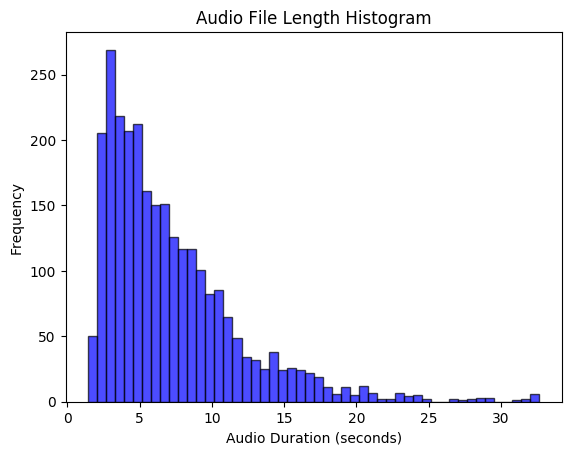

In [6]:
# Display the distribution of lengths of the audio samples
# Function to get audio file lengths
def get_audio_lengths(root_dir):
    audio_lengths = []

    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith(('.wav', '.mp3', '.flac')):
                file_path = os.path.join(subdir, file)
                try:
                    y, sr = librosa.load(file_path, sr=None)
                    duration = librosa.get_duration(y=y, sr=sr)
                    audio_lengths.append(duration)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

    return audio_lengths

root_directory = "./source-data/LibriSpeech/dev-clean/"
audio_lengths = get_audio_lengths(root_directory)
# Create a histogram
plt.hist(audio_lengths, bins=50, alpha=0.7, color='b', edgecolor='black')
plt.xlabel("Audio Duration (seconds)")
plt.ylabel("Frequency")
plt.title("Audio File Length Histogram")
plt.show()

Next we will source the noise samples to be used.

Like the original paper, we will source our noise samples from the [MS-SNSD](https://github.com/microsoft/MS-SNSD/tree/master) dataset however we will chose 6 different noise types than those chosen in the original paper.

>Reddy, C.K., Beyrami, E., Pool, J., Cutler, R., Srinivasan, S. and Gehrke, J., 2019. A scalable noisy speech dataset and online subjective test framework. arXiv preprint arXiv:1909.08050.

In [7]:
# Clone the repository
!git clone https://github.com/microsoft/MS-SNSD.git

Cloning into 'MS-SNSD'...
remote: Enumerating objects: 29924, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 29924 (delta 2), reused 0 (delta 0), pack-reused 29915
Receiving objects: 100% (29924/29924), 3.93 GiB | 19.35 MiB/s, done.
Resolving deltas: 100% (80/80), done.
Checking out files: 100% (24399/24399), done.


In [11]:
# Define the directories to search for .wav files
directories = ["MS-SNSD/noise_test", "MS-SNSD/noise_train"]

# Initialize a set to store unique noise types
unique_noise_types = set()

# Loop through directories
for directory in directories:
    # Use glob to get a list of .wav files in the directory
    wav_files = glob.glob(os.path.join(directory, "*.wav"))
    
    # Loop through .wav files and extract noise types
    for wav_file in wav_files:
        file_name = os.path.basename(wav_file)
        # Split the file name by '_' and get the noise type
        noise_type = file_name.split('_')[0]
        unique_noise_types.add(noise_type)

# Convert the set to a sorted list of unique noise types
unique_noise_types_list = sorted(list(unique_noise_types))

# Print the list of unique noise types
print(f"Unique Noise Types: {', '.join(unique_noise_types_list)}")

Unique Noise Types: AirConditioner, AirportAnnouncement, AirportAnnouncements, Babble, Bus, Cafe, CafeTeria, Car, CopyMachine, Field, Hallway, Kitchen, LivingRoom, Metro, Munching, Neighbor, NeighborSpeaking, Office, Park, Restaurant, ShuttingDoor, Square, SqueakyChair, Station, Traffic, Typing, VacuumCleaner, WasherDryer, Washing


## Data Processing

In this section we will split the data into train, validation, and test splits as well as generate the noise for each audio sample of the correct length and signal to noise ratio.

These samples will be placed into a directory structure which is expected by the NELE-GAN model. That is:
```
├── Test
│   ├── Clean
│   │   ├── sample_name#noise_type#SNR.wav
│   ├── Noise
│   │   ├── sample_name#noise_type#SNR.wav
├── Train
│   ├── Clean
│   │   ├── sample_name2#noise_type#SNR.wav
│   ├── MultiEnh
│   │   ├── sample_name2#noise_type#SNR.wav
│   ├── Noise
└── └── └── sample_name2#noise_type#SNR.wav
```


In [69]:
# Define some helper functions that will help generate the noise files

def snr_mixer(clean, noise, snr):
    # Normalizing to -25 dB FS
    rmsclean = (clean**2).mean()**0.5
    scalarclean = 10 ** (-25 / 20) / rmsclean
    clean = clean * scalarclean
    rmsclean = (clean**2).mean()**0.5

    rmsnoise = (noise**2).mean()**0.5
    scalarnoise = 10 ** (-25 / 20) /rmsnoise
    noise = noise * scalarnoise
    rmsnoise = (noise**2).mean()**0.5
    
    # Set the noise level for a given SNR
    noisescalar = np.sqrt(rmsclean / (10**(snr/20)) / rmsnoise)
    noisenewlevel = noise * noisescalar
    
    # return noise that is the same length as clean signal (NELE-GAN code does not check this)
    if len(noisenewlevel) > len(clean):
        # Truncate noisenewlevel if it is longer than clean
        noisenewlevel = noisenewlevel[:len(clean)]
    else:
        # Repeat noisenewlevel to match the length of clean using numpy broadcasting
        repetitions = -(-len(clean) // len(noisenewlevel))  # Calculate how many times to repeat noisenewlevel
        noisenewlevel = np.tile(noisenewlevel, repetitions)[:len(clean)]  # Repeat noisenewlevel and truncate to the desired length
    
    assert len(noisenewlevel)==len(clean), f"Length of noise is {len(noisenewlevel)} but length of clean is {len(clean)}"
    return clean, noisenewlevel

eps = 1e-4
# Function to read audio
def audioread(path, norm = True, start=0, stop=None):
    path = os.path.abspath(path)
    if not os.path.exists(path):
        raise ValueError("[{}] does not exist!".format(path))
    try:
        x, sr = sf.read(path, start=start, stop=stop)
    except RuntimeError:  # fix for sph pcm-embedded shortened v2
        print('WARNING: Audio type not supported')

    if len(x.shape) == 1:  # mono
        if norm:
            rms = (x ** 2).mean() ** 0.5
            scalar = 10 ** (-25 / 20) / (rms)
            x = x * scalar
        return x, sr
    else:  # multi-channel
        x = x.T
        x = x.sum(axis=0)/x.shape[0]
        if norm:
            rms = (x ** 2).mean() ** 0.5
            scalar = 10 ** (-25 / 20) / (rms)
            x = x * scalar
        return x, sr
    
# Funtion to write audio    
def audiowrite(data, fs, destpath, norm=False):
    if norm:
        rms = (data ** 2).mean() ** 0.5
        scalar = 10 ** (-25 / 10) / (rms+eps)
        data = data * scalar
        if max(abs(data))>=1:
            data = data/max(abs(data), eps)
    
    destpath = os.path.abspath(destpath)
    destdir = os.path.dirname(destpath)
    
    if not os.path.exists(destdir):
        os.makedirs(destdir)
    
    sf.write(destpath, data, fs)
    return

In [70]:
test_speech, test_speech_sr = audioread("source-data/LibriSpeech/dev-clean/174/84280/174-84280-0013.flac")
test_noise, test_noise_sr = audioread("MS-SNSD/noise_train/NeighborSpeaking_14.wav")

test_clean, test_newnoise = snr_mixer(test_speech, test_noise, -13)

# audiowrite(test_clean, test_speech_sr, "test_clean.wav")
# audiowrite(test_newnoise, test_noise_sr, "test_noise.wav")

In [48]:
def get_all_files_in_directory(root_directory):
    file_list = []

    for root, _, files in os.walk(root_directory):
        for file in files:
            if file.endswith(('.wav', '.mp3', '.flac')):
                file_path = os.path.join(root, file)
                file_list.append(file_path)

    return file_list

clean_signals = get_all_files_in_directory('source-data/LibriSpeech/dev-clean/')
# Randomly shuffle the file paths
random.shuffle(clean_signals)

In [ ]:
# Store the configuration in a dictionary
splits_config = {
    "Train": {
        "Size": 0.8,
        "NoiseTypes": ["AirConditioner","NeighborSpeaking", "Munching", "Typing"]
    },
    "Validation": {
        "Size": 0.1,
        "NoiseTypes": ["AirConditioner","NeighborSpeaking", "Munching", "Typing"]
    },
    "Test": {
        "Size": 0.1,
        "NoiseTypes": ["Cafe","VacuumCleaner"]
    }
}

# Define the SNR levels for each noise, values replicated from original paper
noise_snr_config = {
    "AirConditioner":[-11,-7,-3],
    "NeighborSpeaking":[-11,-7,-3],
    "Munching":[-11,-7,-3],
    "Typing":[-11,-7,-3],
    "Cafe":[-9,-5,-1],
    "VacuumCleaner":[-13,-9,-5],
}

In [72]:
# Now write files to expected structure

root_dir = "data"

train_split_size = int(splits_config["Train"]["Size"] * len(clean_signals))
val_split_size = int(splits_config["Validation"]["Size"] * len(clean_signals))
test_split_size = int(splits_config["Test"]["Size"] * len(clean_signals))

train_files = clean_signals[:train_split_size]
val_files = clean_signals[train_split_size:train_split_size + val_split_size]
test_files = clean_signals[train_split_size + val_split_size:]

splits_config["Train"]["Files"] = train_files
splits_config["Validation"]["Files"] = val_files
splits_config["Test"]["Files"] = test_files

# For each split
for split, config in splits_config.items():
    print(f"Generating {split} data...")
    # For each file in the list of files
    for speech_file in config["Files"]:
        # Read the clean file
        speech, speech_sr = audioread(speech_file)
        speech_file_noext = speech_file.split("/")[-1].split(".")[0]
        # For each noise type configured for the split
        for noise_type in config["NoiseTypes"]:
            # Find all the files which match that noise type
            matching_noise_patterns = glob.glob(f"MS-SNSD/noise_*/{noise_type}*")
            # Randomly choose one of the matching noise files
            noise_file = random.choice(matching_noise_patterns)
            noise, noise_sr = audioread(noise_file)
            # For each SNR value for that particular noise type
            for snr in noise_snr_config[noise_type]:
                clean, newnoise = snr_mixer(speech, noise, snr)
                # Finally, write the files to the required folder
                clean_dir = os.path.join(root_dir, split, "Clean", f"{speech_file_noext}#{noise_type}#{snr}.wav")
                audiowrite(clean, speech_sr, clean_dir)
                noise_dir = os.path.join(root_dir, split, "Noise", f"{speech_file_noext}#{noise_type}#{snr}.wav")
                audiowrite(newnoise, noise_sr, noise_dir)

Generating Train data...


LibsndfileError: System error.